In [1]:
import os
import json
import copy

import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Softmax
import matplotlib.pyplot as plt
%matplotlib inline

from datautils.dataset import Alphabet, to_categorical, Dataset
from models.utils import RNN_Hyperparameters
from training import evaluate_rnn
from models.rnn import StepRnn, StepRnnLhuc, RNN_LM, get_rnn_for_hyperparams

LOG_2E = np.log2(np.e)

In [9]:
%%time

modes = ['lhuc', 'static', 'dynamic']

modestats = dict()
models = dict()

lhuc_scalers_history = []
hidden_state_histories = dict((mode, []) for mode in modes)

for mode in ['lhuc', 'static', 'dynamic']:
    use_gpu = True

    exp_dir = '../rnn-experiment-storage/test_small'
# #     exp_dir = '../rnn-experiment-storage/17_bncenren_60_lstm_1024'

    model_id = '1'

    alphabet = Alphabet.from_json(os.path.join(exp_dir, 'alphabet.json'))

    results_file = os.path.join(exp_dir, 'out/results.json')
    with open(results_file, 'r') as fp:
        exp_results = json.load(fp)

    hyperparams = RNN_Hyperparameters(**exp_results[str(model_id)]['config'])

    model = get_rnn_for_hyperparams(hyperparams, alphabet.get_size(), use_gpu)

    checkpoint_path = exp_results[str(model_id)]['path']
    # checkpoint_path = '../rnn-experiment-storage/20_bad_enron_60_lstm_1024/out/0/checkpoints/best.pth.tar'

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    
    if mode == 'lhuc':
        model_step = StepRnnLhuc(model.hidden_dim, model.alphabet_size, model.batch_size, network_type=model.network_type,
                                use_gpu=model.use_gpu)
    else:
        model_step = StepRnn(model.hidden_dim, model.alphabet_size, model.batch_size, network_type=model.network_type,
                                use_gpu=model.use_gpu)

    model_step.rnn_cell.weight_hh.data = model.rnn.weight_hh_l0.data
    model_step.rnn_cell.weight_ih.data = model.rnn.weight_ih_l0.data
    model_step.rnn_cell.bias_hh.data = model.rnn.bias_hh_l0.data
    model_step.rnn_cell.bias_ih.data = model.rnn.bias_ih_l0.data
    model_step.hidden2out.weight.data = model.hidden2out.weight.data
    model_step.hidden2out.bias.data = model.hidden2out.bias.data

    if use_gpu:
        model.cuda()
        model_step.cuda()

    model = model_step
    
    file = 'datasets/test_small/valid.txt'
#     file = 'datasets/misc/test_bg.txt'

#     file = 'datasets/alice/train.txt'

    with open(file, 'r', encoding='utf-8') as fp:
        text = fp.read()
    data = Dataset(file, alphabet)
########

    loss_function = nn.modules.loss.CrossEntropyLoss()
    num_timesteps = 10
    dynamic = mode == 'dynamic'
    learning_rate = 0.1
    lhuc_learning_rate = 0.05
    record_stats=True
    stats_interval=10
    decay_coef=0
    remove_unknown_tokens=False
########

    # In case this is done during training, we do not want to interfere with the model's hidden state - we save that now
    # and recover it at the end of evaluation
    old_hidden = model.hidden
    # We want a batch size of 1 so we can pass through the text sequentially
    model.hidden = model.init_hidden(batch_size=1)
    if mode == 'lhuc':
        model.lhuc_scalers = model.init_lhuc_scalers(batch_size=1)
        model.lhuc_scalers.retain_grad()

    # Get a fresh iterator, so we can make a pass through the whole text
    # TODO: Make sure we iterate through whole file when validating
    # TODO: Fix imprecision in loss calculation
    val_iterator = data.get_batch_iterator(batch_size=1, num_timesteps=num_timesteps,
                                           remove_unknown_tokens=remove_unknown_tokens)

    # Keep track of the total loss, the number of batches we've processed and the time elapsed
    # The last batch might have a different number of timesteps - we need to take that into account when averaging, so
    # instead of counting batches, we count characters processed
    tot_loss = 0
    chars_processed = 0

    if record_stats:
        stats = {'chars_processed': [], 'loss': []}
        chars_since_last_stats = 0

    if dynamic:
        original_weigths = [copy.deepcopy(p.data) for p in model.parameters()]

    for inputs, targets in val_iterator:
        # Make variables volatile - we will not backpropagate here unless we're doing dynamic evaluation
        if use_gpu:
            inputs = Variable(torch.Tensor(inputs), volatile=(not dynamic and not mode == 'lhuc')).cuda()
            targets = Variable(torch.LongTensor(targets), volatile=(not dynamic and not mode == 'lhuc')).cuda()
        else:
            inputs = Variable(torch.Tensor(inputs), volatile=(not dynamic and not mode == 'lhuc'))
            targets = Variable(torch.LongTensor(targets), volatile=(not dynamic and not mode == 'lhuc'))

        if dynamic:
            # Reset the gradiens in prep for a new step
            model.zero_grad()

            old_hidden_values = model.get_hidden_data()
            model.hidden = model.init_hidden(batch_size=None, init_values=old_hidden_values)
        
        if mode == 'lhuc':
            model.zero_grad()
            
            old_hidden_values = model.get_hidden_data()
            model.hidden = model.init_hidden(batch_size=None, init_values=old_hidden_values)
                        

        # Forward pass
        logits = model(inputs)
        
        # Compute the loss on this batch
        # We flatten the results and targets before calculating the loss(pyTorch requires 1D targets) - autograd takes
        # care of backpropagating through the view() operation
        loss = loss_function(logits.contiguous().view(-1, logits.data.shape[-1]), targets.contiguous().view(-1))

        # Calculate average loss (see training function if confused by reshaping) and multiply by the number of
        # timesteps to get the sum of losses for this batch
        tot_loss += loss.data[0] * inputs.shape[1]
        chars_processed += inputs.shape[1]

        if record_stats:
            chars_since_last_stats += inputs.shape[1]
            if chars_since_last_stats >= stats_interval:
                stats['chars_processed'].append(chars_processed)
                stats['loss'].append(LOG_2E * tot_loss / chars_processed)
#                 print('Chars processed: {0}, Loss: {1}'.format(chars_processed, stats['loss'][-1]))
                chars_since_last_stats = 0

        if dynamic:
            # Backward pass - compute gradients, propagate gradient information back through the network
            loss.backward()

            # SGD with global prior update
            for p, o in zip(model.parameters(), original_weigths):
                p.data += - learning_rate * p.grad.data + decay_coef * (o - p.data)
        if mode == 'lhuc':
            loss.backward()
            model.lhuc_scalers.data += -lhuc_learning_rate * model.lhuc_scalers.grad.data
            lhuc_scalers_history.append(model.lhuc_scalers[0].data.cpu().numpy())
        
        hidden_state_histories[mode].append(model.hidden[0].data.cpu().numpy())

    # Restore hidden state
    model.hidden = old_hidden

    modestats[mode] = stats
    models[mode] = model
    print(f'Done for mode {mode}')

Done for mode lhuc
Done for mode static
Done for mode dynamic
Wall time: 4.54 s


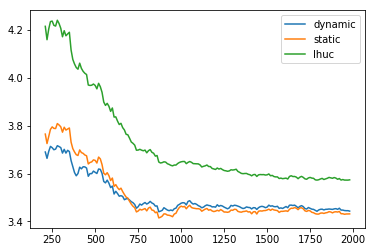

In [10]:
n=20
plt.plot(modestats['dynamic']['chars_processed'][n:], modestats['dynamic']['loss'][n:], label='dynamic')
plt.plot(modestats['static']['chars_processed'][n:], modestats['static']['loss'][n:], label='static')
plt.plot(modestats['lhuc']['chars_processed'][n:], modestats['lhuc']['loss'][n:], label='lhuc')


plt.legend();

In [5]:
def sigmoid(x):
    return 1 / (1 + np.e ** (-x))

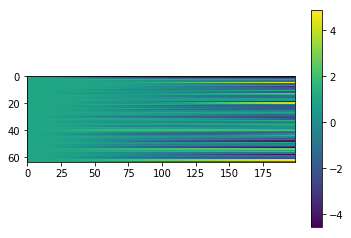

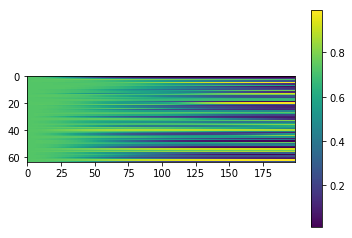

In [12]:
n=0
plt.imshow(np.stack(lhuc_scalers_history[n:]).T)
plt.colorbar()
plt.figure()
plt.imshow(sigmoid(np.stack(lhuc_scalers_history[n:]).T))
plt.colorbar()

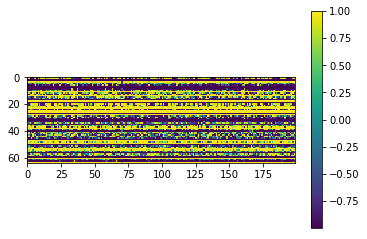

In [14]:
plt.figure()
plt.imshow(np.stack(hidden_state_histories['static']).T)
plt.colorbar()

In [121]:
np.stack(lhuc_scalers_history).shape

(199, 64)

In [80]:
models['lhuc'].lhuc_scalers.size()

torch.Size([1, 1024])

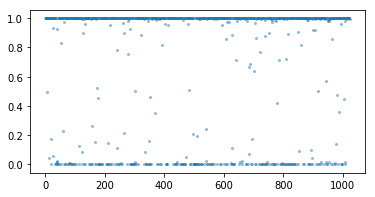

In [92]:
sig = nn.Sigmoid()
fig,ax = plt.subplots(1,1, figsize=(6,3))
ax.scatter(np.arange(1024), sig(models['lhuc'].lhuc_scalers).data.cpu().numpy().reshape(-1), s=4, alpha=0.4)

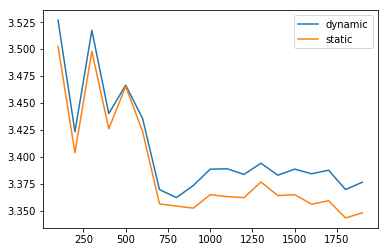

In [10]:
plt.plot(lss[True]['chars_processed'], lss[True]['loss'], label='dynamic')
plt.plot(lss[False]['chars_processed'], lss[False]['loss'], label='static')
plt.legend();